In [134]:
import torch

# Verify if Cuda is available to use GPU
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU está disponible. Usando GPU.")
else:
    device = torch.device("cpu")
    print("GPU no está disponible. Usando CPU.")


GPU está disponible. Usando GPU.


# AI by reinforcement learning 
---
This artificial intelligence will be able to learn to play and complete all levels of Geometry dash, using reinforcement learning. To complete this:
1. Connect python with the game
2. Define bounties and penalizations
3. Use Reinforcement learning like Q-learning, Deep Q-learning or Proximal Policy Optimization
4. Build a neuronal nerwork CNN? 
6. Training
7. Eval and tunning

## 1.Connect Python with the Game
---
This step will require:
1. Keyboard Emulation and Automation
- Description: Simulates keystrokes to control the game.
- Tools: Libraries such as pyautogui in Python can be used to simulate keystrokes.
- Challenges: Can be slow and not always accurate.
2. Use of Computer Vision Tools
- Description: Uses computer vision to "see" the state of the game and makes decisions based on that.
- Tools: Libraries such as OpenCV to process the visual output of the game.
- Challenges: Requires image processing and can be computationally intensive.
3. Creating a Custom Game Environment
- Description: Create a simplified version of Geometry Dash that you can fully control.
- Tools: Programming languages such as Python or JavaScript to create a basic version of the game.
- Challenges: Requires time and effort to replicate the game mechanics.

Capture the game state

In [135]:
# (some auxiliary functions to cpt the game state)
# do actions
import cv2
import numpy as np
import pyautogui

global green_per
green_per = 0.1
def capture_screen(region=(0, 0, 640, 480), resize_dim=(160, 120)):
    global green_per

    screen = pyautogui.screenshot(region=region)
    
    # Convert screenshot into numpy array
    frame = np.array(screen, dtype=np.uint8)
    
    # Convert to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV
    frame_hsv = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2HSV)
    
        # Define range of green color in HSV
    lower_green = np.array([50, 100, 128])
    upper_green = np.array([70, 255, 255])
    # Adjust these values according to your needs
    
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(frame_hsv, lower_green, upper_green)
    
    # Calculate the percentage of green pixels
    green_per = np.sum(mask == 255) / (mask.size) * 100
    
    # Resize image
    frame_resized = cv2.resize(frame_rgb, resize_dim)
    
    # Convert to tensor
    frame_tensor = torch.from_numpy(frame_resized).permute(2, 0, 1).float() / 255.0
    frame_tensor = frame_tensor.unsqueeze(0)
    
    return frame_tensor


In [136]:
import torch
from torchvision.transforms import transforms
class ImageStack:
    def __init__(self, stack_size=4, image_shape=(3, 64, 64)):
        self.stack_size = stack_size
        self.image_shape = image_shape
        self.image_stack = torch.zeros((stack_size, *image_shape), dtype=torch.float32)
        self.idx = 0

    def update_stack(self, processed_image):
        # RESIZE TO C H W
        if processed_image.dim() == 4:
            processed_image = processed_image.squeeze(0)
        
        # Save image and update the idx (indice)
        self.image_stack[self.idx % self.stack_size] = processed_image
        self.idx = (self.idx + 1) % self.stack_size

    def get_stack(self):
        return self.image_stack
    
    def to(self, device):
        self.image_stack = self.image_stack.to(device)

preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
def process_image_pytorch(image, image_stack_obj):
    #print("Procesando imagen")
    # Verify
    image = preprocess(image)
    if not torch.is_tensor(image):
        raise TypeError("La imagen debe ser un tensor de PyTorch.")
    
    # Normalize image
    processed_image = image.float() / 255.0 if image.max() > 1.0 else image.float()

    # Verify
    if processed_image.dim() == 4:
        processed_image = processed_image.squeeze(0)

    # Update stack
    image_stack_obj.update_stack(processed_image)

    #print("Fin del procesamiento de imagen")
    return image_stack_obj.get_stack()


## 2 Define bounties

Now let's define the rewards, we will give 1 point for staying alive, and subtract when eliminated.

In [137]:
import numpy as np
import cv2
import torch
import time
import matplotlib.pyplot as plt

## Seems working properly detecting the block
def get_bounty():
    #print("Green percentage: ", green_percentage)
    if green_per < 10:
        return 30
    else:
        #print("Green percentage: ", green_percentage)
        return 0 


In [138]:
"""greens = []
while True:
    capture_screen()
    greens.append(green_per)
    if green_per == 0:
        print("HA TERMINADO")"""


'greens = []\nwhile True:\n    capture_screen()\n    greens.append(green_per)\n    if green_per == 0:\n        print("HA TERMINADO")'

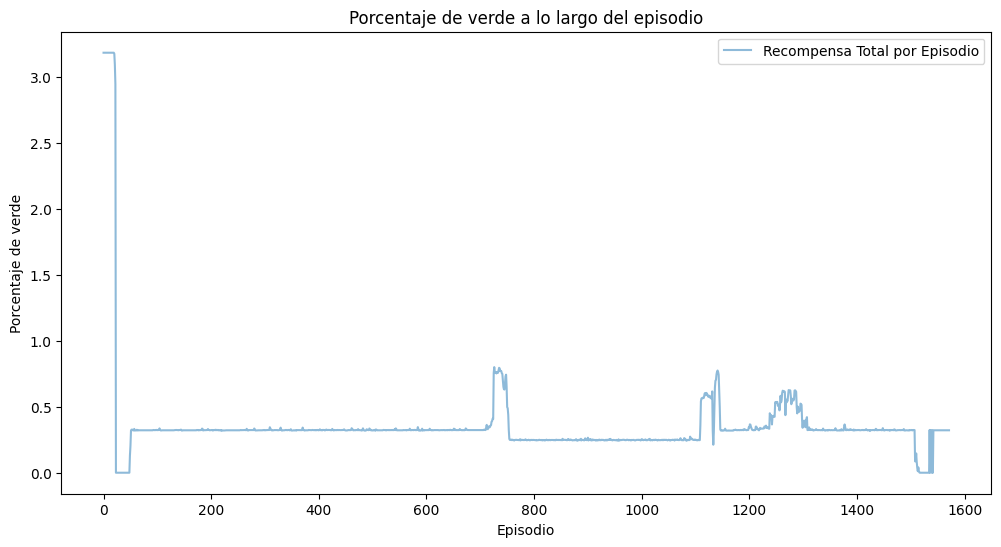

In [139]:

plt.figure(figsize=(12, 6))
plt.plot(greens, label='Recompensa Total por Episodio', alpha=0.5)
plt.title('Porcentaje de verde a lo largo del episodio')
plt.xlabel('Episodio')
plt.ylabel('Porcentaje de verde')
plt.legend()
plt.show()

## 3 Use Reinforcement learning
---


First of all we need a buffer of repetitions and some auxiliary functions

In [140]:
import random

def choose_action(state, model, epsilon, device):
    if random.random() > epsilon:
        single_state = state.unsqueeze(0) if state.dim() == 3 else state[:1]  # Usa solo la primera observación si hay más
        single_state = single_state.to(device)
        
        with torch.no_grad():
            q_values = model(single_state)
            action = q_values.max(1)[1].item()
            print(f"Accion predecida {action}")
    else:
        action = random.randrange(num_actions)
    return action


def update_network(model, target_model, minibatch, gamma, optimizer, criterion):
    states, actions, rewards, next_states, dones = minibatch
    states = states.to(device)
    next_states = next_states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    dones = dones.to(device)
   
    states = states[:, -1, :, :, :] 
    next_states = next_states[:, -1, :, :, :]
    # Calculate q values
    current_q_values = model(states).gather(1, actions.unsqueeze(-1))
    next_q_values = target_model(next_states).max(1)[0].detach()
    expected_q_values = rewards + (gamma * next_q_values * (1 - dones.float()))
    expected_q_values = expected_q_values.unsqueeze(1)

    loss = criterion(current_q_values.squeeze(-1), expected_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def perform_action_pytorch(action, screen):
    bounty = get_bounty() 
    if action == 0:
        pyautogui.click()
        bounty+=5
    if green_per == 0:
        return  bounty, True

    return bounty, False


create the model


In [141]:
import torch
import torch.nn as nn
from torchvision import models, transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

class GeometryDashCNN(nn.Module):
    def __init__(self, num_actions):
        super(GeometryDashCNN, self).__init__()
        self.num_actions = num_actions
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.flattened_size = 128 * 16 * 16

       
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc3 = nn.Linear(128, num_actions)

        # load pretrained GoogLeNet
        googlenet = models.googlenet(pretrained=True)
        
        self.googlenet = googlenet
        self.googlenet.fc = nn.Linear(self.googlenet.fc.in_features, num_actions)
        

    def forward(self, x):
        # For the moment just use googleNet
        x = self.googlenet(x)
        return x

    #def forward(self, x):
        # Aplicar la primera capa convolucional y pooling
    #    x = self.pool(F.relu(self.conv1(x)))
        # Aplicar la segunda capa convolucional y pooling
    #    x = self.pool(F.relu(self.conv2(x)))
        # Aplicar la tercera capa convolucional sin pooling
    #    x = F.relu(self.conv3(x))
        # Aplanar los datos para la entrada densa
    #    x = x.view(-1, self.flattened_size)
        # Aplicar las capas densas con activaciones ReLU
    #    x = F.relu(self.fc1(x))
    #    x = self.fc3(x)  # Directamente los valores lineales sin softmax
    #    return x



import random
from collections import deque
import os 
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        minibatch = random.sample(self.buffer, batch_size)
        
        # Desempaqueta y organiza los datos del minibatch en tensores PyTorch
        states = torch.stack([item[0] for item in minibatch])
        actions = torch.tensor([item[1] for item in minibatch])
        rewards = torch.tensor([item[2] for item in minibatch])
        next_states = torch.stack([item[3] for item in minibatch])
        dones = torch.tensor([item[4] for item in minibatch])
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)
    
replay_buffer = ReplayBuffer(20)


Lets start to play

In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time


# Parameters
gamma = 0.99  # Discount 
epsilon = 1.0  # Epsilon to start epsilon-greedy politic
epsilon_min = 0.00001  # min Epsilon
epsilon_decay = 0.995  # Factor de decaimiento de epsilon
learning_rate = 0.01  # Learning Rate
replay_buffer_capacity = 10000  # Max buffer capacity
minibatch_size = 16  # Batxh size
num_episodes = 10000 
num_actions = 2 # jump or not jump
path = './model.pth'
model = GeometryDashCNN(num_actions=num_actions)
TARGET_UPDATE_FREQUENCY = 20

if  os.path.exists(path):
    model.load_state_dict(torch.load('/model.pth'))
model = model.to(device)


target_model = GeometryDashCNN(num_actions=num_actions)
target_model = target_model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
image_shape = (3,120, 160)
image_stack_obj = ImageStack(stack_size=4, image_shape=image_shape)
image_stack_obj.to(device)

time.sleep(5)
all_rewards = []
for episode in range(num_episodes):
    time.sleep(0.2)
    screen = capture_screen()
    state = process_image_pytorch(screen, image_stack_obj)
    done = False
    total_reward = 0

    while not done:
        time.sleep(0.1)
        # Select Action ε-greedy policy
        action = choose_action(state, model, epsilon, device=device)
        reward, done = perform_action_pytorch(action, screen)
        screen = capture_screen()
        new_state = process_image_pytorch(screen, image_stack_obj)
        total_reward += reward

        # safe buffer
        replay_buffer.store(state, action, reward, new_state, done)

        # update network
        if len(replay_buffer) >= minibatch_size:
            minibatch = replay_buffer.sample(minibatch_size)
            loss = update_network(model, target_model, minibatch, gamma, optimizer, criterion)  # Actualiza la red
    
    if episode % TARGET_UPDATE_FREQUENCY == 0:
        target_model.load_state_dict(model.state_dict())
    print(f'Episodio: {episode}, Recompensa Total: {total_reward}, Epsilon: {epsilon}')

    all_rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    state = new_state
    torch.save(model.state_dict(), './model_weights.pth')




e:\AI_FOR_Geometry_dash\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\AI_FOR_Geometry_dash\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Episodio: 0, Recompensa Total: 225, Epsilon: 1.0


e:\AI_FOR_Geometry_dash\.venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episodio: 1, Recompensa Total: 370, Epsilon: 0.995
Episodio: 2, Recompensa Total: 90, Epsilon: 0.990025
Episodio: 3, Recompensa Total: 95, Epsilon: 0.985074875
Episodio: 4, Recompensa Total: 70, Epsilon: 0.9801495006250001
Accion predecida 1
Episodio: 5, Recompensa Total: 90, Epsilon: 0.9752487531218751
Episodio: 6, Recompensa Total: 95, Epsilon: 0.9703725093562657
Accion predecida 1
Episodio: 7, Recompensa Total: 30, Epsilon: 0.9655206468094844
Episodio: 8, Recompensa Total: 190, Epsilon: 0.960693043575437
Episodio: 9, Recompensa Total: 65, Epsilon: 0.9558895783575597
Episodio: 10, Recompensa Total: 65, Epsilon: 0.9511101304657719
Episodio: 11, Recompensa Total: 100, Epsilon: 0.946354579813443
Episodio: 12, Recompensa Total: 100, Epsilon: 0.9416228069143757
Episodio: 13, Recompensa Total: 35, Epsilon: 0.9369146928798039


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
# Calcular el promedio móvil de las recompensas
def calcular_promedio_movil(recompensas, ventana=500):
    """Calcula el promedio móvil de las recompensas con una ventana dada."""
    promedios = np.convolve(recompensas, np.ones(ventana)/ventana, mode='valid')
    return promedios

promedio_movil_recompensas = calcular_promedio_movil(all_rewards, ventana=50)

# Graficar las recompensas promedio por episodio
plt.figure(figsize=(12, 6))
plt.plot(all_rewards, label='Recompensa Total por Episodio', alpha=0.5)
plt.plot(np.arange(len(promedio_movil_recompensas)) + 50/2, promedio_movil_recompensas, color='red', label='Promedio Móvil')
plt.title('Recompensa Promedio por Episodio a lo Largo del Tiempo')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Promedio')
plt.legend()
plt.show()

ValueError: v cannot be empty